# CROSS VALIDATION
Cross validation is used when there are limited experimental data. This notebook is about using cross validation to assess the accuracy of parameter estimation, especially the sensitivity of the results to the observational data.

*Step 1: Create **folds**.*
* Each fold is a partition of the original dataset into **training* data and **test data**.
* The set of test data across folds is a partition of the original data set. That is, every observation is in exactly one test data set.

*Step 2: Perform parameter estimation on each fold.*
* Parameters are estimated using the training data for the fold.

*Step 3: Quantify the accuracy of parameter estimation.*
* The parameter estimates in step 2 are used to predict the values of the test data.
* The accuracy of the predictions are evaluated (e.g., using $R^2$).

*Step 4: Evaluate the result.*
* Are parameter values consistent across folds?
* Are the accuracy measures sufficiently "good"?

We will create synthetic observational data that we'll use in the steps above.

# Preliminaries

In [17]:
# First code cell in a notebook contains all installs
try:
    import lmfit
except:
    !apt-get install libncurses5
    !pip install -q tellurium==2.2.8
    !pip install lmfit

In [2]:
%matplotlib inline
import collections
import tellurium as te
import lmfit
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt

# Models

In [3]:
SIMPLE_MODEL = """
     A -> B; k1*A
     B -> C; k2*B

     A = 5;
     B = 0;
     C = 0;
     k1 = 0.1
     k2 = 0.2
"""

In [4]:
# A kinetic mechanism for nicotinic acetylcholine receptors based on multiple allosteric transitions\
URL_2 = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL6614086398/2/BIOMD0000000002_url.xml"
rr = te.loadSBMLModel(URL_2)
print(rr.getAntimony())

// Created by libAntimony v2.13.2
model *BIOMD0000000002()

  // Compartments and Species:
  compartment comp1;
  species BLL in comp1, IL in comp1, AL in comp1, A in comp1, BL in comp1;
  species B in comp1, DLL in comp1, D in comp1, ILL in comp1, DL in comp1;
  species I in comp1, ALL in comp1, L in comp1;

  // Reactions:
  React0: B + L -> BL; comp1*(kf_0*B*L - kr_0*BL);
  React1: BL + L -> BLL; comp1*(kf_1*BL*L - kr_1*BLL);
  React2: BLL -> ALL; comp1*(kf_2*BLL - kr_2*ALL);
  React3: A + L -> AL; comp1*(kf_3*A*L - kr_3*AL);
  React4: AL + L -> ALL; comp1*(kf_4*AL*L - kr_4*ALL);
  React5: B -> A; comp1*(kf_5*B - kr_5*A);
  React6: BL -> AL; comp1*(kf_6*BL - kr_6*AL);
  React7: I + L -> IL; comp1*(kf_7*I*L - kr_7*IL);
  React8: IL + L -> ILL; comp1*(kf_8*IL*L - kr_8*ILL);
  React9: A -> I; comp1*(kf_9*A - kr_9*I);
  React10: AL -> IL; comp1*(kf_10*AL - kr_10*IL);
  React11: ALL -> ILL; comp1*(kf_11*ALL - kr_11*ILL);
  React12: D + L -> DL; comp1*(kf_12*D*L - kr_12*DL);
  React13: DL

# Helpers and Constants

In [5]:
# Experimental conditions
SIMTIME = 30
NOISE_STD = 0.5
NUM_POINT = 300
# Provides the parameters for models considered in this notebook
PARAMETER_DCT = {"simple_model": ["k1", "k2"], 2: ["kf_0", "kr_1"]}
MODELS = {"simple_model": SIMPLE_MODEL, 2: URL_2}
MODEL_NAMES = list(PARAMETER_DCT.keys())  # Names of the models

In [6]:
def makeParameters(model_name):
    """
    Creates parameters for a model that is described
    """
    if not model_name in PARAMETER_DCT.keys():
        raise ValueError("Invalid model name.")
    parameters = lmfit.Parameters()
    for parameter_name in PARAMETER_DCT[model_name]:
        parameters.add(parameter_name, min=0, value=1, max=100000)
    return parameters

# Tests
parameters = makeParameters("simple_model")
assert(isinstance(parameters, lmfit.Parameters))
print("OK!")

OK!


In [7]:
def runSimulation(sim_time, num_point, parameters=None, roadrunner=None,
                  model=None):
    """
    Runs the simulation model for the model parameters.
    :param int sim_time: time to run the simulation
    :param int num_point: number of timepoints simulated
    :param lmfit.Parameters parameters:
    :param tellurium.roadrunner.extended_roadrunner.ExtendedRoadRunner road_runner:
    :param str model (Antimony or URL).
    :return named_array:
    """
    if roadrunner is None:
        try:
            roadrunner = te.loada(model)
        except:
            roadrunner = te.loadSBMLModel(model)
    else:
        roadrunner.reset()
    if parameters is not None:
        parameter_dict = parameters.valuesdict()
        # Set the simulation constants for all parameters
        for constant in parameter_dict.keys():
            roadrunner[constant] = parameter_dict[constant]
            #stmt = "roadrunner.%s = parameter_dict['%s']" % (constant, constant)
            #exec(stmt)
    return roadrunner.simulate(0, sim_time, num_point)

# Tests
data = runSimulation(SIMTIME, NUM_POINT, parameters=makeParameters("simple_model"), model=SIMPLE_MODEL)
assert(np.shape(data) == (NUM_POINT, 4))
#
data = runSimulation(SIMTIME, NUM_POINT, parameters=makeParameters(2), model=URL_2)
print("OK!")

OK!


# Create synthetic observational data

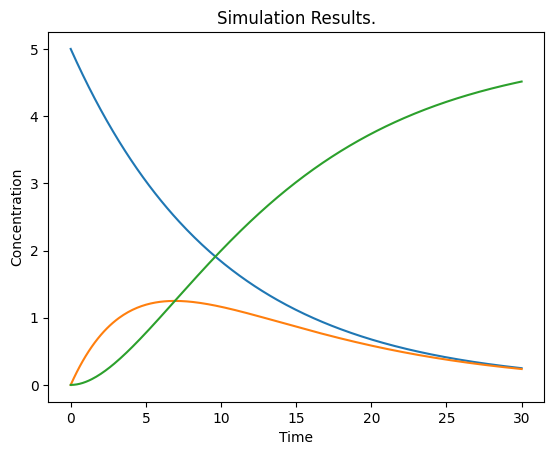

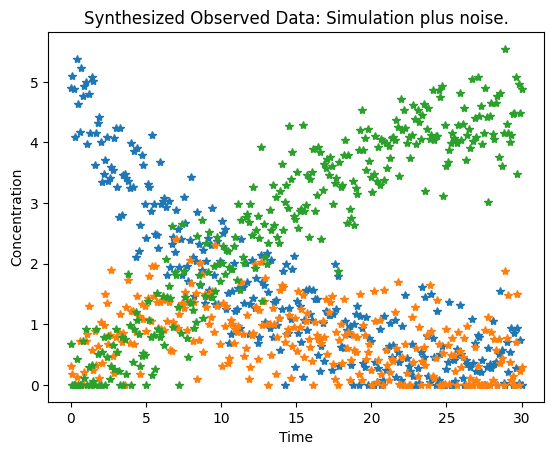

In [8]:
# Create the experimental data. We refer to these as the observations
data = runSimulation(SIMTIME, NUM_POINT, model=SIMPLE_MODEL)
num_cols = len(data.colnames) - 1

# Create some 'experimental' data
x_data = data[:, 0]  # Times
obs_data = data.copy()
obs_data = obs_data[:,1:]   # Values of chemical species

for i in range (NUM_POINT):
    for j in range(num_cols):
        obs_data[i, j] = max(obs_data[i, j] + np.random.normal(0, NOISE_STD, 1), 0)


# Plot the simulation data.
plt.plot (x_data, data[:, 1:])
plt.title("Simulation Results.")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.show()

# Plot the observed data.
plt.plot (x_data, obs_data, marker='*', linestyle='None')
plt.title("Synthesized Observed Data: Simulation plus noise.")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.show()


# Step 1: Create folds

In [9]:
class Fold:
    # A class that contains a fold
    
    def __init__(self, training_idxs, test_idxs):
        """
        Args:
           training_idxs: np.array-int (indices in the data set that are used for training)
           test_indices: np.array-int (indices used to test)
        """
        self.training_idxs = np.array(training_idxs).astype(int)
        self.test_idxs = np.array(test_idxs).astype(int)
        
    def __repr__(self):
        return str(self.training_idxs) + " " + str(self.test_idxs)
        
# Tests
training_idxs = [1, 2, 3]
test_idxs = [4, 5]
fold = Fold(training_idxs, test_idxs)
assert(np.allclose(training_idxs, fold.training_idxs))
assert(np.allclose(test_idxs, fold.test_idxs))
print("OK!")

OK!


In [10]:
def makeFolds(num_point, num_fold):
    """
    Calculates training and test indices for folds. Folds rotate across observations. That is, the n-th value
    in fold m is observation n*m.
    Assumes that num_fold evenly divides num_point.

    Args:
        num_point: int (total number of points)
        num_fold: int (number of folds)
    Returns:
        list-Fold (a list of folds)
    """
    if num_point % num_fold != 0:
        raise ValueError("The number of folds must evently divide the number of points")
    folds = []
    #
    all_idxs = set(range(num_point))
    test_size = num_point // num_fold
    test_base_idxs = np.array(range(test_size))
    for idx in range(num_fold):
        test_idxs = idx + test_base_idxs
        train_idxs = list(all_idxs.difference(test_idxs))
        fold = Fold(train_idxs, test_idxs)
        folds.append(fold) 
    #
    return folds
# Test
num_point = 10
num_fold = 5
folds = makeFolds(num_point, num_fold)
assert(len(folds) == num_fold)
assert(len(folds[0].test_idxs)== num_point//num_fold)  # Number of test observations in a fold
print("OK!")

OK!


# Step 2: Calculate parameter estimates for each fold

In [11]:
# Create the results
def calculateFoldResults(model, parameter_names, obs_data, num_fold):
    """
    Estimates parameters for each fold and calculates its R2

    Args:
        model: Antimony model
        parameter_names: list-str (names of parameters to estimate)
        obs_data: Observational data
        num_fold: number of folds
    Returns:
        pd.DataFrame
            index: fold
            columns: parameter
    """
    try:
        roadrunner = te.loada(model)
    except:
        roadrunner = te.loadSBMLModel(model)
    def calcResiduals(parameters, indices):
        """
        Runs a simulation with the specified parameters and calculates residuals
        for the indices.
        """
        sim_data = runSimulation(SIMTIME, len(obs_data), roadrunner=roadrunner,
                                 parameters=parameters)
        sim_data = sim_data[:, 1:]  # Skip time
        residuals = obs_data[indices, :] - sim_data[indices, :]
        return residuals.flatten()
    #
    # Estimate the parameters for each fold
    folds = makeFolds(len(obs_data), num_fold)
    # Construct the result container
    result_dct = {n: [] for n in parameter_names}
    for fold in folds:
        # Set the parameters for this fold
        parameters = lmfit.Parameters()
        for name in parameter_names:
            parameters.add(name, value=1, min=0, max=10)
        fitter_result = lmfit.minimize(calcResiduals, parameters, args=(fold.training_idxs, ))
        # Calculate the RSQ value for the test indices
        test_predictions = runSimulation(SIMTIME, NUM_POINT, roadrunner=roadrunner,
                                    parameters=fitter_result.params)
        test_predictions = test_predictions[fold.test_idxs, 1:]
        test_obs = obs_data[fold.test_idxs, :]
        residuals = test_obs.flatten() - test_predictions.flatten()
        rsq = 1 - np.var(residuals)/np.var(test_obs.flatten())
        # Accumulate the results
        values_dct = fitter_result.params.valuesdict()
        for name in parameter_names:
            result_dct[name].append(values_dct[name])
    df = pd.DataFrame(result_dct)
    df.index.name = "fold"
    return df

# Tests
fold_df =  calculateFoldResults(SIMPLE_MODEL, ["k1", "k2"], obs_data, 3)
for idx in fold_df.index:
    assert(isinstance(fold_df.loc[idx, "k1"], float))
    assert(isinstance(fold_df.loc[idx, "k2"], float))
print("OK!")

OK!


In [12]:
fold_df

,k1,k2
fold,,
0,6.587653,0.085619
1,0.100255,0.199297
2,0.100411,0.198961


# Step 3: Quantify the accuracy of the fold parameter estimates

In [13]:
# Create the results
def evaluateAccuracy(model, fold_df, obs_data):
    """
    Estimates parameters for each fold and calculates its R2

    Args:
        model: str (Antimony model or URL)
        fold_df: DataFrame
            row: fold
            columns: parameter values
        obs_data: np.array (observational data)
    Returns:
        pd.Series
            index: fold index
            value: rsq
    """
    # Get the roadrunner
    try:
        roadrunner = te.loada(model)
    except:
        roadrunner = te.loadSBMLModel(model)
    # Evaluate the prediction accuracy of each fold
    results = []
    for idx in fold_df.index:
        parameters = lmfit.Parameters()
        for parameter_name in fold_df.columns:
            parameters.add(parameter_name, value = fold_df.loc[idx, parameter_name])
        test_predictions = runSimulation(SIMTIME, NUM_POINT, roadrunner=roadrunner,
                                    parameters=parameters)
        test_predictions = test_predictions[test_idxs, 1:]
        test_obs = obs_data[test_idxs, :]
        residuals = test_obs.flatten() - test_predictions.flatten()
        rsq = 1 - np.var(residuals)/np.var(test_obs.flatten())
        # Accumulate the results
        results.append(rsq)
    ser = pd.Series(results)
    ser.index.name = "fold"
    return ser

# Tests
fold_df =  calculateFoldResults(SIMPLE_MODEL, ["k1", "k2"], obs_data, 3)
rsq_ser = evaluateAccuracy(SIMPLE_MODEL, fold_df, obs_data)
print("OK!")

OK!


# Step 4: Evaluate the results

In [15]:
fold_df =  calculateFoldResults(SIMPLE_MODEL, ["k1", "k2"], obs_data, 3)
fold_df

,k1,k2
fold,,
0,6.587653,0.085619
1,0.100255,0.199297
2,0.100411,0.198961


In [16]:
evaluateAccuracy(SIMPLE_MODEL, fold_df, obs_data)

fold
0    -1.700420238286334
1    0.9837107722266647
2    0.9836965503676074
dtype: object

1. Are parameter values consistent?
1. Is $R^2$ close to 1?

# Exercise

Consider the model in URL2
1. Generate synthetic observational data for 300 points with a standard deviation of 0.2.
1. Compare the cross validation results for:
    1. 3 folds
    1. 10 folds
    1 30 folds